# Preamble

In [1]:
import glob
import os
import pandas as pd
import numpy as np
import seaborn as sns
import wikitextparser as wtp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
%matplotlib inline
from datetime import datetime
import calendar
from ast import literal_eval
import string
import urllib.parse as up

# Lists

In [2]:
# API variables
api_url = 'https://yugipedia.com/api.php'
sets_query_url = '?action=ask&query=[[Category:Set%20Card%20Lists]]|limit%3D5000|order%3Dasc&format=json'
lists_query_url = '?action=query&prop=revisions&rvprop=content&format=json&titles='

rarity_dict = {'c': 'Common', 'r': 'Rare', 'sr': 'Super Rare', 'ur': 'Ultra Rare', 'utr': 'Ultimate Rare', 'n': 'Normal', 'nr': 'Normal Rare', 'sp': 'Short Print', 'ssp': 'Super Short Print', 'hfr': 'Holofoil Rare', 'scr': 'Secret Rare', 'uscr': 'Ultra Secret Rare', 'scur': 'Secret Ultra Rare', 'pscr': 'Prismatic Secret Rare', 'hgr': 'Holographic Rare', ' gr': 'Ghost Rare', 'pr': 'Parallel Rare', 'npr': 'Normal Parallel Rare', 'pc': 'Parallel Common', 'spr': 'Super Parallel Rare', 'upr': 'Ultra Parallel Rare', 'dnpr': 'Duel Terminal Normal Parallel Rare', 'dpc': 'Duel Terminal Parallel Common', 'drpr': 'Duel Terminal Rare Parallel Rare', 'dspr': 'Duel Terminal Super Parallel Rare', 'dupr': 'Duel Terminal Ultra Parallel Rare', 'DScPR': 'Duel Terminal Secret Parallel Rare', 'gur': 'Gold Rare', 'escr': 'Extra Secret Rare', 'ggr': 'Ghost/Gold Rare', 'shr': 'Shatterfoil Rare', 'cr': 'Collector\'s Rare', 'altr': 'Starlight Rare', 'str': 'Starlight Rare', 'gr': 'Ghost Rare', 'gscr': 'Gold Secret Rare', 'sfr': 'Starfoil Rare', '20scr': '20th Secret Rare', 'dscpr': 'Duel Terminal Secret Parallel Rare', 'dnrpr': 'Duel Terminal Normal Rare Parallel Rare','kcc': 'Kaiba Corporation Common' }
regions_dict = {'EN':'English', 'NA': 'North American English','EU':'European English', 'AU': 'Oceanic English', 'PT': 'Portuguese', 'DE': 'German', 'FC': 'French-Canadian', 'FR': 'French', 'IT': 'Italian', 'SP': 'Spanish', 'JP': 'Japanese', 'JA': 'Japanese-Asian', 'AE': 'Asian-English', 'KR': 'Korean', 'TC': 'Traditional Chinese', 'SC': 'Simplified Chinese'}

# Get set lists

In [3]:
df = pd.read_json(f'{api_url}{sets_query_url}')
keys = list(df['query']['results'].keys())

all_set_lists = pd.DataFrame(columns = ['Set','Card number','Name','Rarity','Print','Quantity','Region'])
step = 50

for i in range(np.ceil(len(keys)/step).astype(int)):
    if i%10 == 0:
        print(f'Iteration {i}')
    first = i*step
    last = (i+1)*step
    titles = up.quote('|'.join(keys[first:last]))
    df = pd.read_json(f'{api_url}{lists_query_url}{titles}')
    contents = df['query']['pages'].values()
    
    for content in contents:
        if 'revisions' in  content.keys():
            temp = content['revisions'][0]['*']
            parsed = wtp.parse(temp)
            
            for template in parsed.templates:
                if template.name == 'Set list':
                    title = content['title'].split('Lists:')[1]
                    set_df = pd.DataFrame(columns = ['Set', 'Card number', 'Name', 'Rarity', 'Print', 'Quantity'])


                    region = None
                    rarity = None
                    card_print = None
                    qty = None
                    desc = None
                    opt = None
                    list_df = None
                    
                    for argument in template.arguments:
                        if 'region=' in argument:
                            region = argument.string[argument.string.index('=')+1:]
                        elif 'rarities=' in argument:
                            rarity = tuple(rarity_dict.get(i.strip().lower(), string.capwords(i.strip())) for i in argument.string[argument.string.index('=')+1:].split(','))
                        elif 'print=' in argument:
                            card_print = argument.string[argument.string.index('=')+1:]
                        elif 'qty=' in argument:
                            qty = argument.string[argument.string.index('=')+1:]
                        elif 'description=' in argument:
                            desc = argument.string[argument.string.index('=')+1:]
                        elif 'options=' in argument:
                            opt = argument.string[argument.string.index('=')+1:]
                        else:
                            set_list = argument.string[2:-1]
                            lines = set_list.split('\n')

                            list_df = pd.DataFrame([x.split(';') for x in lines])
                            list_df = list_df[~list_df[0].str.contains('!:')]
                            list_df = list_df.applymap(lambda x: x.split('//')[0] if x is not None else x)
                            list_df = list_df.applymap(lambda x: x.strip() if x is not None else x)
                            list_df.replace(r'^\s*$', None, regex = True, inplace = True)

                    if opt != 'noabbr':
                        set_df['Card number'] = list_df[0]
                        set_df['Name'] = list_df[1]
                    else: 
                        set_df['Name'] = list_df[0]

                    if len(list_df.columns)>2: # and rare in str
                        set_df['Rarity'] = list_df[2].apply(lambda x: tuple([rarity_dict.get(y.strip().lower(), string.capwords(y.strip())) for y in x.split(',')]) if x is not None else rarity)
                    else:
                        set_df['Rarity'] = [rarity for _ in set_df.index]

                    if len(list_df.columns)>3 :
                        if card_print is not None: # and new/reprint in str
                            set_df['Print'] = list_df[3].apply(lambda x: x if x is not None else card_print)
                            if len(list_df.columns)>4 and qty is not None:
                                set_df['Quantity'] = list_df[4].apply(lambda x: x if x is not None else qty)
                        elif qty is not None:
                            set_df['Quantity'] = list_df[3].apply(lambda x: x if x is not None else qty)
                    
                    set_df['Set'] = title.split("(")[0].strip()
                    set_df['Quantity'] = pd.to_numeric(set_df['Quantity'])
                    set_df['Region'] = region.upper()
                    all_set_lists = pd.concat([all_set_lists, set_df], ignore_index=True)
                    
        else:
            print('Error:', content['title'])


all_set_lists = all_set_lists.convert_dtypes()
all_set_lists.sort_values(by=['Set','Region','Card number']).reset_index(inplace = True)

Iteration 0
Error: Set Card Lists:Yu-Gi-Oh! World Championship 2004 prize cards (OCG-AE)
Error: Set Card Lists:Sneak Peek Participation Cards: Series 6 (TCG-IT)
Error: Set Card Lists:The Dark Illusion: Special Edition (TCG-IT)
Error: Set Card Lists:Pharaoh Tour 2006 promotional cards (TCG-DE)
Error: Set Card Lists:The Dark Illusion: Special Edition (TCG-DE)
Error: Set Card Lists:Invasion: Vengeance: Special Edition (TCG-SP)
Error: Set Card Lists:Duelist Set: DX Double Union (OCG-JP)
Error: Set Card Lists:Sneak Peek Participation Cards: Series 6 (TCG-FR)
Error: Set Card Lists:Yu-Gi-Oh! 5D's World Championship 2010: Reverse of Arcadia Game Guide promotional card (OCG-JP)
Error: Set Card Lists:Structure Deck: Warrior's Strike (OCG-JP)
Error: Set Card Lists:Sneak Peek Participation Cards: Series 6 (TCG-DE)
Error: Set Card Lists:Yu-Gi-Oh! World Championship 2007 Game Guide promotional card (OCG-JP)
Error: Set Card Lists:The Dark Illusion: Special Edition (TCG-PT)
Error: Set Card Lists:Sneak

# Get set properties

In [4]:
info = ['Cover card','Series','Set type','Modification date']
release = [i+' release date' for i in set(regions_dict.values())]
ask = up.quote('|'.join(np.append(info,release)))
first_timestamp = info.index('Modification date')
sets = all_set_lists['Set'].unique()
step = 15

info_df = pd.DataFrame()
for i in range(np.ceil(len(sets)/step).astype(int)):
    if i%10 ==0:
        print(f'Iteration {i}')
    first = i*step
    last = (i+1)*step
    titles = up.quote(']]OR[['.join(sets[first:last]))
    response = pd.read_json(f'{api_url}?action=askargs&conditions={titles}&printouts={ask}&format=json')
    results = pd.DataFrame(response['query']['results']).T
    printouts = pd.DataFrame(results['printouts'].values.tolist(), index = results.index)
    printouts.iloc[:, :first_timestamp] = printouts.iloc[:, :first_timestamp].applymap(lambda x: tuple([y['fulltext'] for y in x]) if len(x)>0 else None)
    printouts.iloc[:, first_timestamp:] = printouts.iloc[:, first_timestamp:].applymap(lambda x: pd.to_datetime(x[0]['timestamp'], unit = 's', errors = 'coerce') if len(x)>0 else None)
    info_df = pd.concat([info_df, printouts])

info_df = info_df.convert_dtypes()
info_df

Iteration 0
Iteration 10
Iteration 20
Iteration 30
Iteration 40
Iteration 50
Iteration 60
Iteration 70
Iteration 80
Iteration 90


Cover card  \
Advanced Event Pack 2014 Vol.1                                         None   
Advanced Event Pack 2015 Vol.2                                         None   
Ancient Prophecy                                    (Ancient Fairy Dragon,)   
Battle City Tournament Kit                                             None   
Battle Pack Tournament Prize Cards                                     None   
...                                                                     ...   
Japan Championship 2021 Shop Qualifiers partici...                     None   
Japan Championship 2022 Shop Qualifiers prize c...                     None   
Judge promotional cards                                                None   
Jump Festa 2004 promotional cards                                      None   
Jump Festa 2005 promotional cards                                      None   

                                                             Series  \
Advanced Event Pack 2014 Vol.1                                 None   
Advanced Event Pack 2015 Vol.2                                 None   
Ancient Prophecy                                    (Core Booster,)   
Battle City Tournament Kit                                     None   
Battle Pack Tournament Prize Cards                             None   
...                                                             ...   
Japan Championship 2021 Shop Qualifiers partici...             None   
Japan Championship 2022 Shop Qualifiers prize c...             None   
Judge promotional cards                                        None   
Jump Festa 2004 promotional cards                              None   
Jump Festa 2005 promotional cards                              None   

                                                                    Set type  \
Advanced Event Pack 2014 Vol.1                               (Booster pack,)   
Advanced Event Pack 2015 Vol.2                               (Booster pack,)   
Ancient Prophecy                                             (Booster pack,)   
Battle City Tournament Kit                              (Promotional cards,)   
Battle Pack Tournament Prize Cards                            (Prize cards,)   
...                                                                      ...   
Japan Championship 2021 Shop Qualifiers partici...       (Promotional card,)   
Japan Championship 2022 Shop Qualifiers prize c...       (Promotional card,)   
Judge promotional cards                                  (Promotional card,)   
Jump Festa 2004 promotional cards                   (Tournament prize card,)   
Jump Festa 2005 promotional cards                        (Promotional card,)   

                                                     Modification date  \
Advanced Event Pack 2014 Vol.1                     2022-07-23 19:36:37   
Advanced Event Pack 2015 Vol.2                     2022-07-23 19:39:03   
Ancient Prophecy                                   2022-11-05 18:39:37   
Battle City Tournament Kit                         2017-02-06 00:20:52   
Battle Pack Tournament Prize Cards                 2021-03-06 02:50:08   
...                                                                ...   
Japan Championship 2021 Shop Qualifiers partici... 2022-03-11 12:20:20   
Japan Championship 2022 Shop Qualifiers prize c... 2022-04-09 09:43:16   
Judge promotional cards                            2017-07-25 20:57:30   
Jump Festa 2004 promotional cards                  2022-11-06 04:44:51   
Jump Festa 2005 promotional cards                  2022-11-06 05:15:26   

                                                   Asian-English release date  \
Advanced Event Pack 2014 Vol.1                                            NaT   
Advanced Event Pack 2015 Vol.2                                            NaT   
Ancient Prophecy                                                          NaT   
Battle City Tournament Kit                                                NaT   
Battle P

# Add release date to set lists

In [5]:
all_set_lists['Release'] = all_set_lists[['Set','Region']].apply(lambda x: info_df[regions_dict[x['Region']]+' release date'][x['Set']] if (x['Region'] in regions_dict.keys() and x['Set'] in info_df.index) else None, axis = 1)
all_set_lists['Release'] = pd.to_datetime(all_set_lists['Release'].astype(str), errors='coerce') # Bug fix

# Data visualization

In [6]:
all_set_lists

Set Card number  \
0          Advanced Event Pack 2014 Vol.1  AE03-KR001   
1          Advanced Event Pack 2014 Vol.1  AE03-KR002   
2          Advanced Event Pack 2014 Vol.1  AE03-KR003   
3          Advanced Event Pack 2014 Vol.1  AE03-KR004   
4          Advanced Event Pack 2014 Vol.1  AE03-KR005   
...                                   ...         ...   
152265            Judge promotional cards  TKN4-EN036   
152266  Jump Festa 2004 promotional cards     PC3-006   
152267  Jump Festa 2004 promotional cards     PC3-007   
152268  Jump Festa 2005 promotional cards   PC5-JP007   
152269  Jump Festa 2005 promotional cards   PC5-JP008   

                             Name                          Rarity Print  \
0                       Dark Hole                  (Secret Rare,)  <NA>   
1          Number 106: Giant Hand                  (Secret Rare,)  <NA>   
2                 Ghostrick Witch                  (Secret Rare,)  <NA>   
3                  Fiendish Chain                  (Secret Rare,)  <NA>   
4        Aurkus, Lightsworn Druid                   (Super Rare,)  <NA>   
...                           ...                             ...   ...   
152265                      Token                   (Super Rare,)  <NA>   
152266  Kycoo the Ghost Destroyer  (Common, Normal Parallel Rare)  <NA>   
152267       Bazoo the Soul-Eater  (Common, Normal Parallel Rare)  <NA>   
152268   Dark Balter the Terrible  (Common, Normal Parallel Rare)  <NA>   
152269                 Ryu Senshi  (Common, Normal Parallel Rare)  <NA>   

        Quantity Region    Release  
0           <NA>     KR 2014-01-04  
1           <NA>     KR 2014-01-04  
2           <NA>     KR 2014-01-04  
3           <NA>     KR 2014-01-04  
4           <NA>     KR 2014-01-04  
...          ...    ...        ...  
152265      <NA>     EN        NaT  
152266      <NA>     JP 2003-12-20  
152267      <NA>     JP 2003-12-20  
152268      <NA>     JP 2004-12-18  
152269      <NA>     JP 2004-12-18  

[152270 rows x 8 columns]

## By Set

In [7]:
print('Total number of sets:', all_set_lists['Set'].nunique())

Total number of sets: 1426


In [8]:
all_set_lists.groupby('Set', dropna=False).nunique()

Card number  Name  Rarity  \
Set                                                                            
"Amabie-San" Present Campaign                                2     2       1   
"Blue-Eyes White Dragon Rush Rare Special Red ...            2     1       1   
"Blue-Eyes White Dragon Secret Rare Special Bl...            1     1       1   
"Blue-Eyes White Dragon" 20th Anniversary Gold...            0     1       0   
"Blue-Eyes White Dragon" 20th Anniversary Silv...            0     1       0   
...                                                        ...   ...     ...   
Yu-Gi-Oh! ZEXAL World Duel Carnival Duel Champ...            1     1       1   
Yu-Gi-Oh! ZEXAL World Duel Carnival promotiona...           18     3       1   
Yugi's Legendary Decks                                     650   113       3   
Zexal Collection Tin                                       120    24       3   
Zombie World Structure Deck                                185    37       2   

                                                   Print  Quantity  Region  \
Set                                                                          
"Amabie-San" Present Campaign                          0         0       1   
"Blue-Eyes White Dragon Rush Rare Special Red ...      0         0       2   
"Blue-Eyes White Dragon Secret Rare Special Bl...      0         0       1   
"Blue-Eyes White Dragon" 20th Anniversary Gold...      0         0       1   
"Blue-Eyes White Dragon" 20th Anniversary Silv...      0         0       1   
...                                                  ...       ...     ...   
Yu-Gi-Oh! ZEXAL World Duel Carnival Duel Champ...      0         0       1   
Yu-Gi-Oh! ZEXAL World Duel Carnival promotiona...      0         0       6   
Yugi's Legendary Decks                                 0         0       5   
Zexal Collection Tin                                   0         0       5   
Zombie World Structure Deck                            0         2       5   

                                                   Release  
Set                                                         
"Amabie-San" Present Campaign                            1  
"Blue-Eyes White Dragon Rush Rare Special Red ...        2  
"Blue-Eyes White Dragon Secret Rare Special Bl...        1  
"Blue-Eyes White Dragon" 20th Anniversary Gold...        1  
"Blue-Eyes White Dragon" 20th Anniversary Silv...        1  
...                                                    ...  
Yu-Gi-Oh! ZEXAL World Duel Carnival Duel Champ...        1  
Yu-Gi-Oh! ZEXAL World Duel Carnival promotiona...        2  
Yugi's Legendary Decks                                   2  
Zexal Collection Tin                                     1  
Zombie World Structure Deck                              1  

[1426 rows x 7 columns]

## By Card number

In [9]:
print('Total number of card numbers:', all_set_lists['Card number'].nunique())

Total number of card numbers: 149205


In [10]:
all_set_lists.groupby('Card number', dropna=False).nunique()

Set  Name  Rarity  Print  Quantity  Region  Release
Card number                                                     
15AX-JP000     2     1       1      1         0       1        1
15AX-JPM01     1     1       1      1         0       1        1
15AX-JPM02     1     1       1      1         0       1        1
15AX-JPM03     1     1       1      1         0       1        1
15AX-JPM04     1     1       1      1         0       1        1
...          ...   ...     ...    ...       ...     ...      ...
ZTIN-SP021     1     1       1      0         0       1        1
ZTIN-SPV01     1     1       1      0         0       1        1
ZTIN-SPV02     1     1       1      0         0       1        1
ZTIN-SPV03     1     1       1      0         0       1        1
<NA>          41   409       6      2         0      10       39

[149206 rows x 7 columns]

## By Name

In [11]:
print('Total number of card names:', all_set_lists['Name'].nunique())

Total number of card names: 12664


In [12]:
all_set_lists.groupby('Name', dropna=False).nunique()

Set  Card number  Rarity  Print  Quantity  \
Name                                                                       
"A Legendary Ocean"              1            1       0      0         0   
"A" Cell Breeding Device         4            9       1      1         0   
"A" Cell Incubator               2            8       1      2         0   
"A" Cell Recombination Device    1            8       1      0         0   
"A" Cell Scatter Burst           3            9       1      1         0   
...                            ...          ...     ...    ...       ...   
Zubaba Knight                   12           50       5      1         1   
Zubababancho Gagagacoat          1            2       1      1         0   
Zure, Knight of Dark World       8           24       1      1         1   
Zushin the Sleeping Giant        3           14       3      1         0   
<NA>                             8          170       3      0         0   

                               Region  Release  
Name                                            
"A Legendary Ocean"                 1        1  
"A" Cell Breeding Device            7        6  
"A" Cell Incubator                  7        6  
"A" Cell Recombination Device       8        4  
"A" Cell Scatter Burst              7        6  
...                               ...      ...  
Zubaba Knight                       8       23  
Zubababancho Gagagacoat             2        2  
Zure, Knight of Dark World         10       14  
Zushin the Sleeping Giant           8        4  
<NA>                                9       13  

[12665 rows x 7 columns]

## By Rarity

In [13]:
print('Total number of rarities:', all_set_lists['Rarity'].explode().nunique())

Total number of rarities: 53


### By unique

In [14]:
all_set_lists.explode('Rarity').groupby('Rarity', dropna = False).nunique()

Set  Card number  Name  Print  \
Rarity                                                                   
10000 Secret Rare                          2            7     1      1   
20th Secret Rare                          16          135   134      3   
@released::(from July 17)                  1            1     1      0   
@released::(from July 31)                  1            1     1      0   
@released::(from September 18)             1            2     1      0   
Collector's Rare                           5          211    61      2   
Collectors Rare                            8          112   112      2   
Common                                   550        75986  8582      5   
Duel Terminal Normal Parallel Rare        38         1211   511      0   
Duel Terminal Normal Rare Parallel Rare    5           15    15      0   
Duel Terminal Rare Parallel Rare          34          368   141      0   
Duel Terminal Secret Parallel Rare        16          103    55      0   
Duel Terminal Super Parallel Rare         34          240    85      0   
Duel Terminal Ultra Parallel Rare         42          211    87      0   
Extra Secret Parallel Rare                 3           10     6      0   
Extra Secret Rare                         24           77    50      1   
Ghost Rare                                35          220    47      3   
Ghost/Gold Rare                            1           30     6      0   
Gold Rare                                 23         2057   363      2   
Gold Rush Rare                             2           16    16      2   
Gold Secret Rare                           8          644   154      2   
Holographic Parallel Rare                  2            2     2      1   
Holographic Rare                          67          122    64      2   
Kaiba Corporation Common                  10           10    10      0   
Kaiba Corporation Rare                     5            5     5      0   
Kaiba Corporation Ultra Rare               3            3     3      0   
Millennium Gold Rare                       2            9     6      2   
Millennium Rare                            8          316   152      3   
Millennium Secret Rare                     1            4     2      1   
Millennium Super Rare                      1           40    20      1   
Millennium Ultra Rare                      1           16     8      1   
Mosaic Rare                                1         1290   215      0   
New                                        2            1    18      1   
Normal Parallel Rare                     130         2038   995      3   
Normal Rare                               80          571   295      2   
Platinum Secret Rare                       2           24     4      0   
Prismatic Secret Rare                     38         1200   349      3   
Rare                                     247        18312  3447      6   
Reprint                                    6            0    35      0   
Rush Rare                                 15           98    49      0   
Secret Parallel Rare                       2           12     6      1   
Secret Rare                              372        10318  2294      9   
Shatterfoil Rare                           4         1482   293      0   
Short Print                               56         1323   234      3   
Starfoil Rare                              6         2019   380      0   
Starlight Rare                            12          316    56      2   
Super Parallel Rare                        6          154    82      3   
Super Rare                               578        20057  3872      9   
Super Short Print                          1           35     5      1   
Ultimate Rare                            115         4313   842      2   
Ultra Parallel Rare                       67          279   170      3   
Ultra Rare                               782        17037  3192      7   
Ultra Secret Rare                          1 

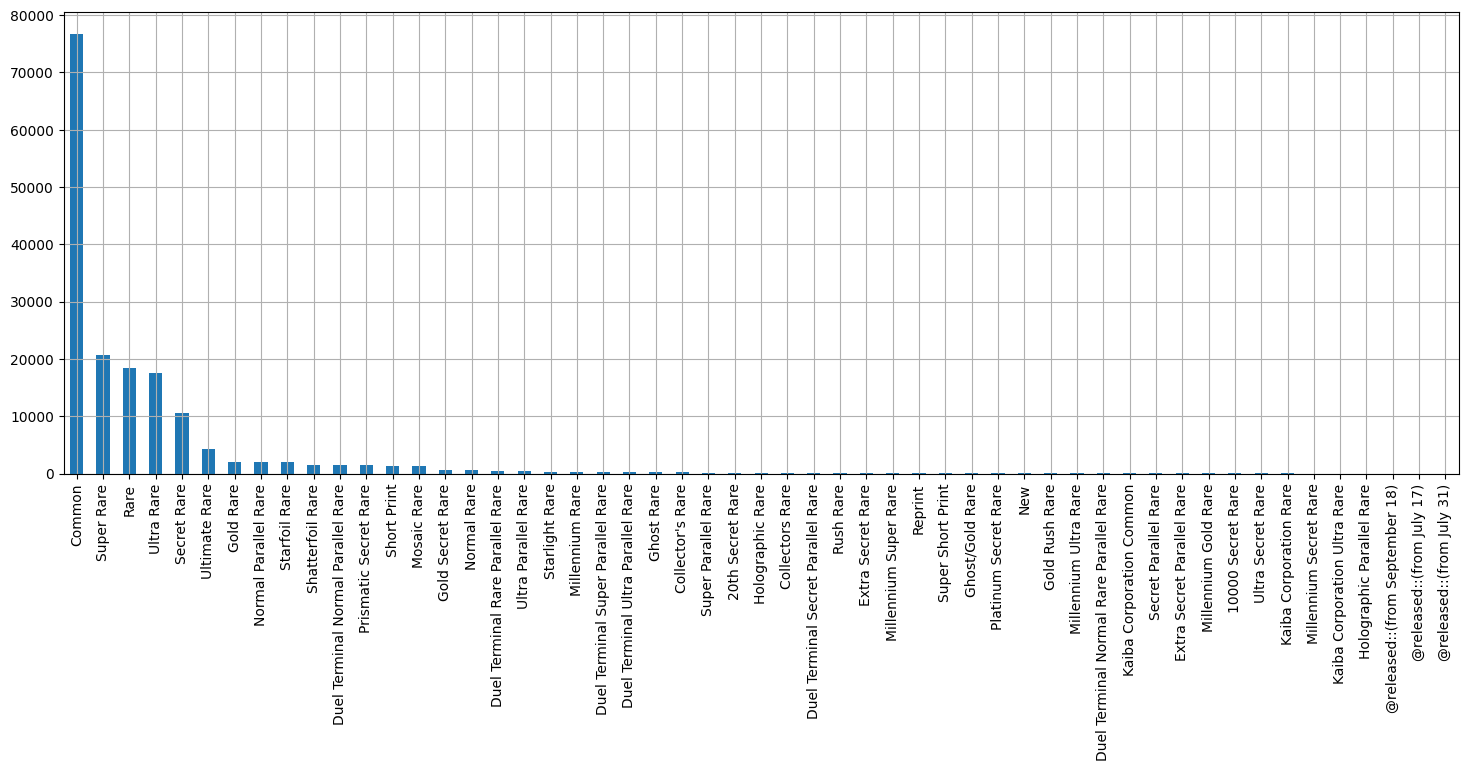

In [15]:
all_set_lists['Rarity'].explode().value_counts().plot.bar(figsize = (18,6), grid=True)
plt.show()

### By combination

In [16]:
all_set_lists.groupby('Rarity', dropna = False).nunique()

Set  Card number  Name  \
Rarity                                                                     
(10000 Secret Rare,)                                2            7     1   
(20th Secret Rare,)                                 9           25    24   
(@released::(from July 17),)                        1            1     1   
(@released::(from July 31),)                        1            1     1   
(@released::(from September 18),)                   1            2     1   
...                                               ...          ...   ...   
(Ultra Rare, Ultimate Rare, Ultra Parallel Rare)    1            1     1   
(Ultra Rare, Ultra Parallel Rare)                  22           71    67   
(Ultra Rare, Ultra Parallel Rare, Ultimate Rare)    5            5     5   
(Ultra Secret Rare,)                                1            0     6   
NaN                                                34          379   376   

                                                  Print  Quantity  Region  \
Rarity                                                                      
(10000 Secret Rare,)                                  1         0       7   
(20th Secret Rare,)                                   1         0       1   
(@released::(from July 17),)                          0         0       1   
(@released::(from July 31),)                          0         0       1   
(@released::(from September 18),)                     0         0       1   
...                                                 ...       ...     ...   
(Ultra Rare, Ultimate Rare, Ultra Parallel Rare)      0         0       1   
(Ultra Rare, Ultra Parallel Rare)                     0         0       1   
(Ultra Rare, Ultra Parallel Rare, Ultimate Rare)      0         0       1   
(Ultra Secret Rare,)                                  0         0       1   
NaN                                                   2         0       6   

                                                  Release  
Rarity                                                     
(10000 Secret Rare,)                                    2  
(20th Secret Rare,)                                     8  
(@released::(from July 17),)                            0  
(@released::(from July 31),)                            0  
(@released::(from September 18),)                       0  
...                                                   ...  
(Ultra Rare, Ultimate Rare, Ultra Parallel Rare)        1  
(Ultra Rare, Ultra Parallel Rare)                      16  
(Ultra Rare, Ultra Parallel Rare, Ultimate Rare)        3  
(Ultra Secret Rare,)                                    1  
NaN                                                    30  

[124 rows x 7 columns]

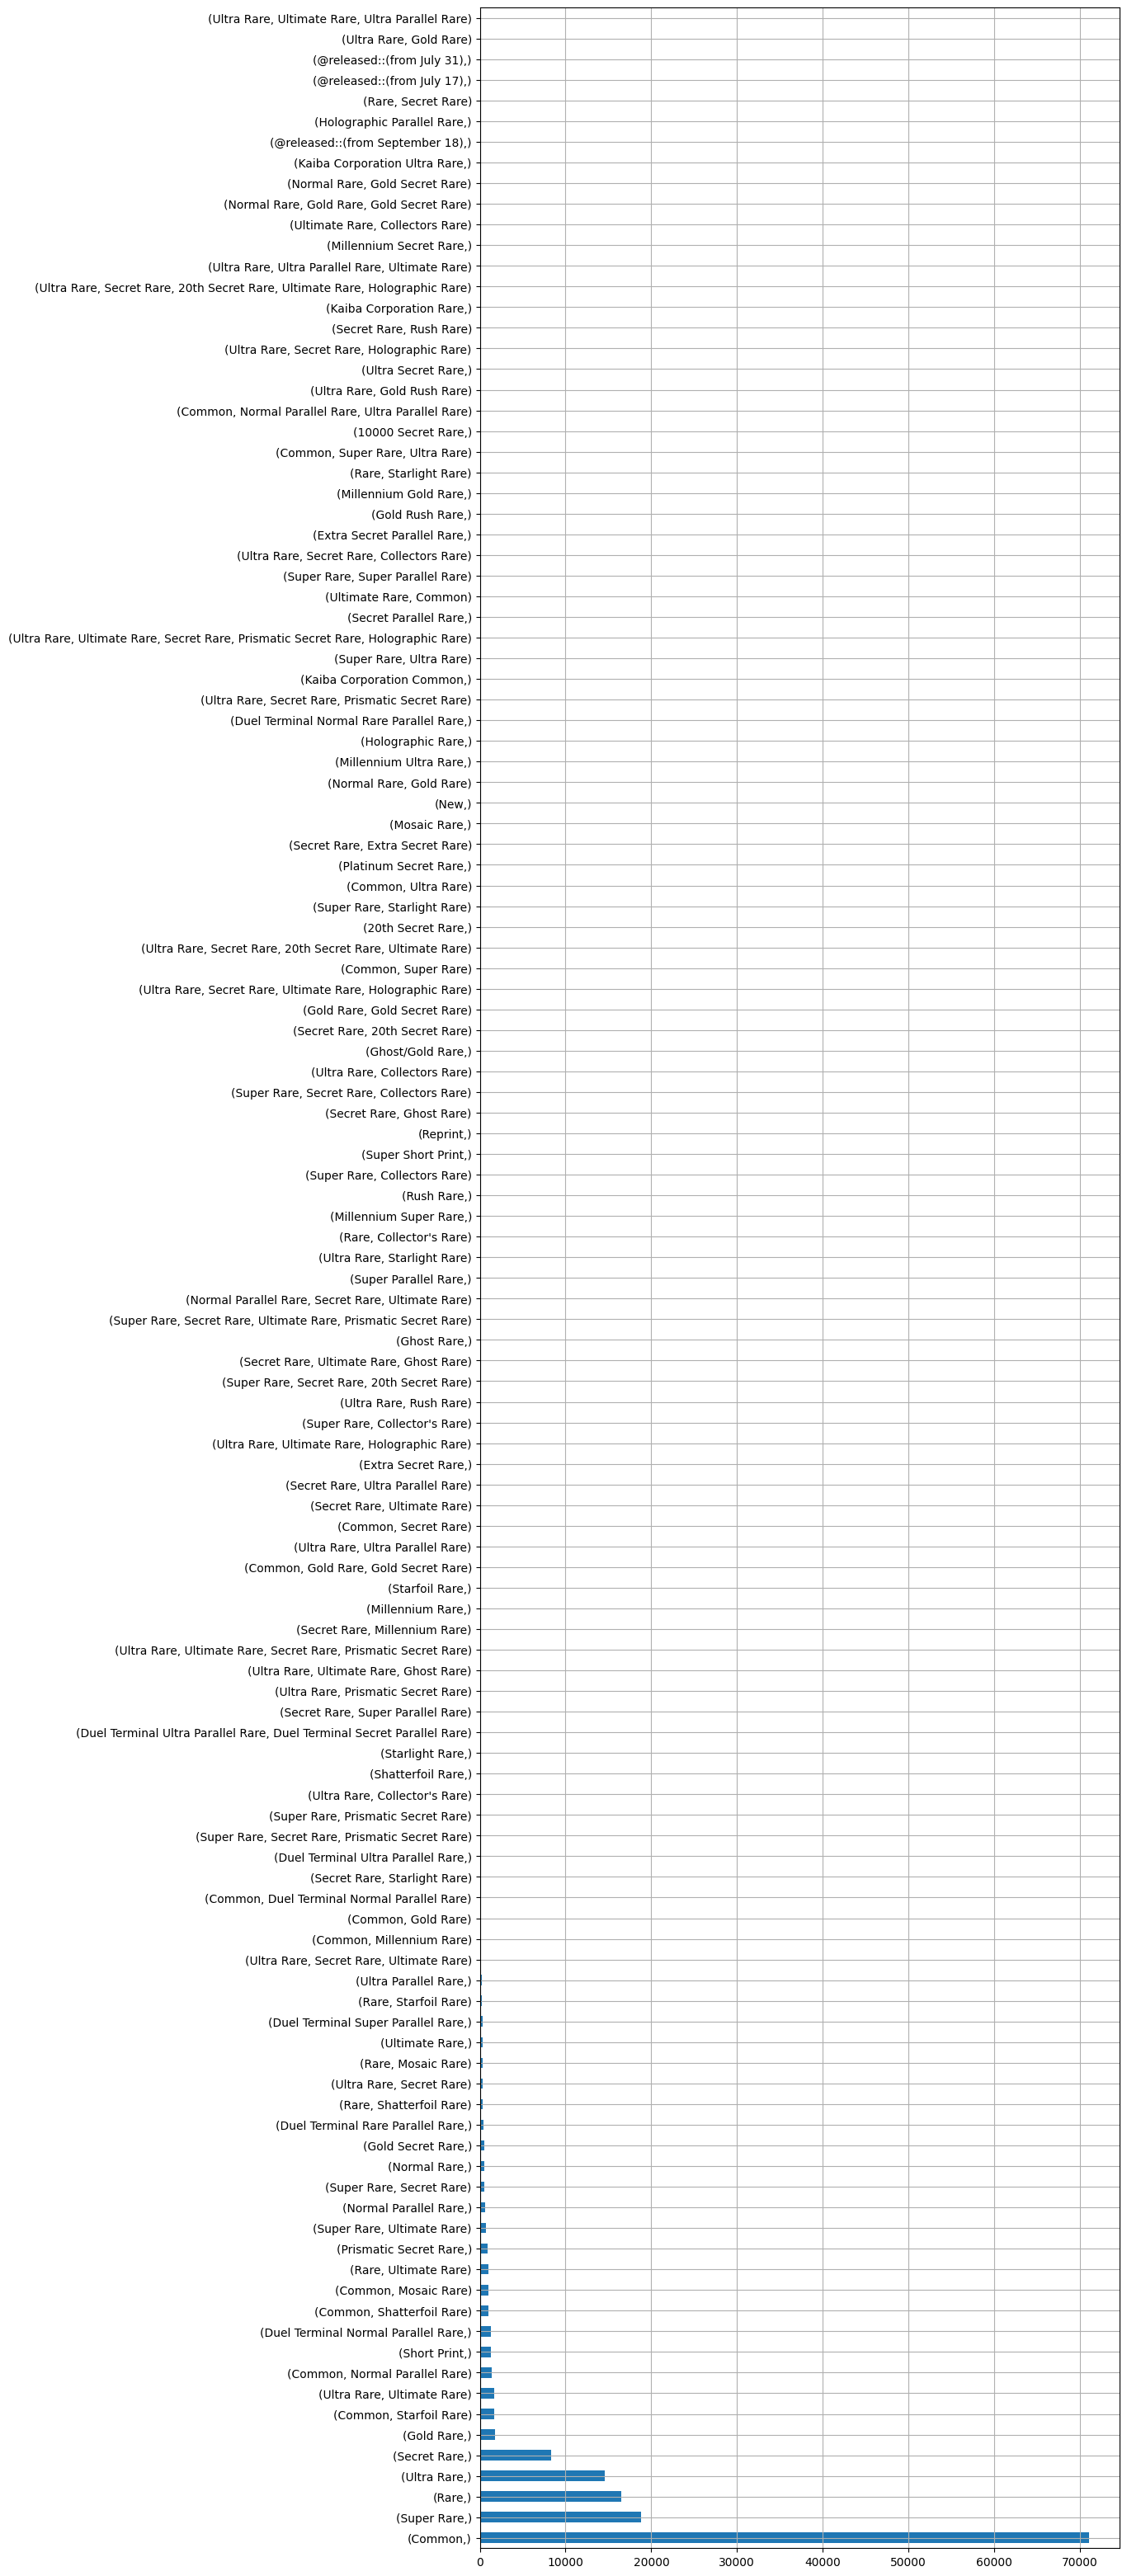

In [17]:
all_set_lists['Rarity'].value_counts().plot.barh(figsize = (10,40), grid=True)
plt.show()

## By Print

In [18]:
print('Total number of prints:', all_set_lists['Print'].nunique())

Total number of prints: 14


In [19]:
all_set_lists.groupby('Print', dropna=False).nunique()

Set  Card number   Name  Rarity  Quantity  \
Print                                                                     
2                               1            0      1       0         0   
European & Oceanian debut       1            6      6       1         0   
European debut                 12          146    146       5         0   
Functional errata               1            2      2       1         0   
New                           201        10882   3650      44         3   
New art                         1            4      2       1         0   
New artwork                     8           58     14       4         0   
New artwork (renamed)           1            3      3       1         0   
North American debut            2            4      4       2         0   
Oceanian debut                  1            1      1       1         0   
Reprint                       200        11554   4180      44         3   
Reprint (New Art)               2            2      1       2         0   
Reprint (functional errata)    15           33     21      10         0   
Reprint (renamed)               2           76     76       6         0   
<NA>                         1357       126580  11501     112         3   

                             Region  Release  
Print                                         
2                                 1        1  
European & Oceanian debut         1        1  
European debut                    2       10  
Functional errata                 1        1  
New                              11      218  
New art                           2        2  
New artwork                       7       11  
New artwork (renamed)             1        1  
North American debut              2        2  
Oceanian debut                    1        1  
Reprint                          11      216  
Reprint (New Art)                 2        2  
Reprint (functional errata)       8       14  
Reprint (renamed)                 1        2  
<NA>                             17     1461

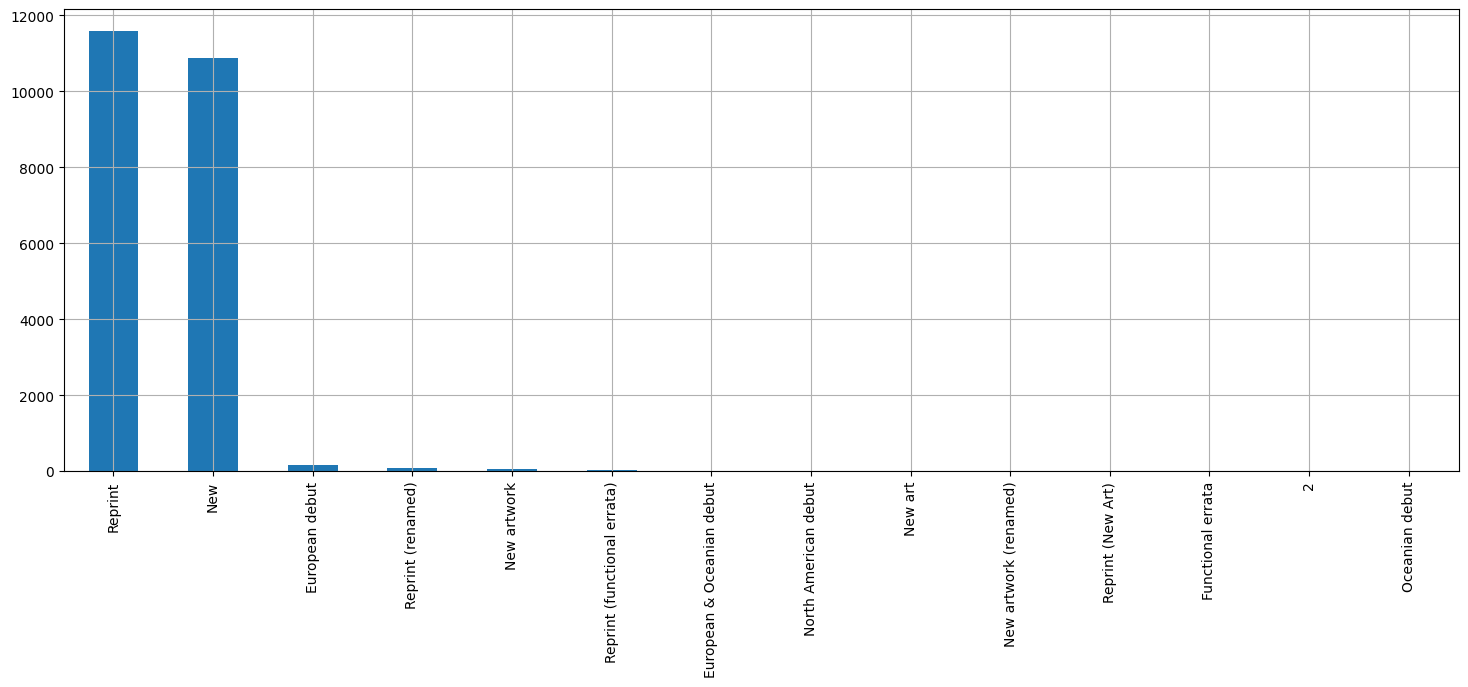

In [20]:
all_set_lists['Print'].value_counts().plot.bar(figsize = (18,6), grid=True)
plt.show()

## By Quantity

In [21]:
print('Total number of quantities:', all_set_lists['Quantity'].nunique())

Total number of quantities: 3


In [22]:
all_set_lists.groupby('Quantity', dropna=False).nunique()

Set  Card number   Name  Rarity  Print  Region  Release
Quantity                                                          
1           67         8900   1216      11      2      11      108
2           66          856    173       4      2      11      108
3           10           74     25       1      2       8       12
<NA>      1361       139387  12552     122     14      17     1503

## By Region

In [23]:
print('Total number of regions:', all_set_lists['Region'].nunique())

Total number of regions: 17


In [24]:
all_set_lists.groupby('Region', dropna=False).nunique()

Set  Card number   Name  Rarity  Print  Quantity  Release
Region                                                           
AE       34         1527   1493      12      0         2       31
AU        2          100     87       3      0         0        0
DE      451        19676  10226      43      4         3      379
EN      671        20683  10588      51     12         3      548
ES        1          100    100       7      0         0        0
EU       27          753    659       8      3         0       17
FC        3          102     87       3      0         0        1
FR      446        19266  10282      44      4         3      374
IT      443        19355  10221      44      4         3      374
JA        3          185    185       8      0         0        3
JP      708        19007  11220      91      7         3      528
KR      381        15824  10748      55      4         3      331
NA       49         1732   1522      10      3         2       41
PT      200        11765   7525      38      4         3      162
SC       21         1031    973      11      2         0       21
SP      412        18415  10054      43      4         3      352
TC        7          300    286      12      0         2        5

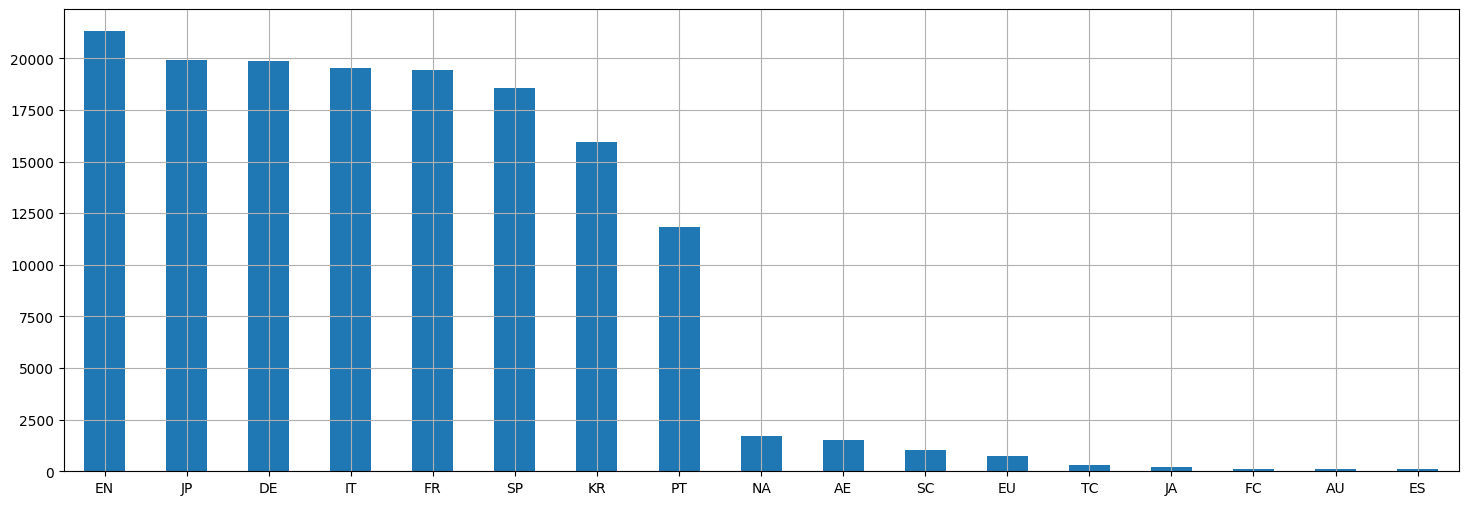

In [25]:
all_set_lists['Region'].value_counts().plot.bar(figsize = (18,6), grid=True, rot=0)
plt.show()

## By Release

In [26]:
print('Total number of release dates:', all_set_lists['Release'].nunique())

Total number of release dates: 1574


In [27]:
all_set_lists.groupby('Release', dropna=False).nunique()

Set  Card number  Name  Rarity  Print  Quantity  Region
Release                                                            
1999-03-01    1            0    40       1      0         0       1
1999-03-18    1            0     1       0      0         0       1
1999-04-29    1            0     1       0      0         0       1
1999-05-05    1            0     1       0      0         0       1
1999-05-25    1            0    40       1      0         0       1
...         ...          ...   ...     ...    ...       ...     ...
2023-01-14    1           80     8       2      0         0       1
2023-01-19    1           60     3       1      0         0       1
2023-03-01    1            1     1       1      0         0       1
2023-05-01    2            2     2       1      0         0       1
NaT         123         4413  1294      28      4         2      15

[1575 rows x 7 columns]

In [28]:
set_by_date = pd.DataFrame(all_set_lists.groupby('Release', dropna=False)['Set'].nunique())

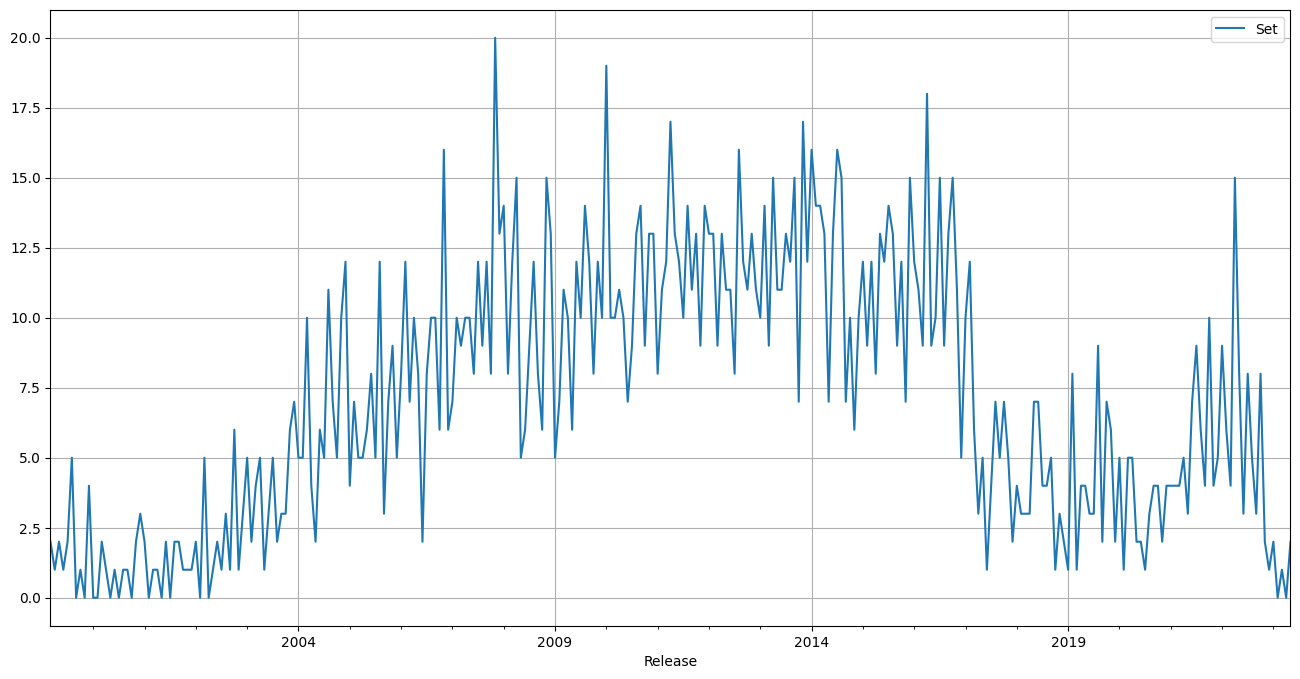

In [29]:
set_by_date.resample('M').sum().plot(figsize= (16,8), grid = True, x_compat=False)
plt.show()

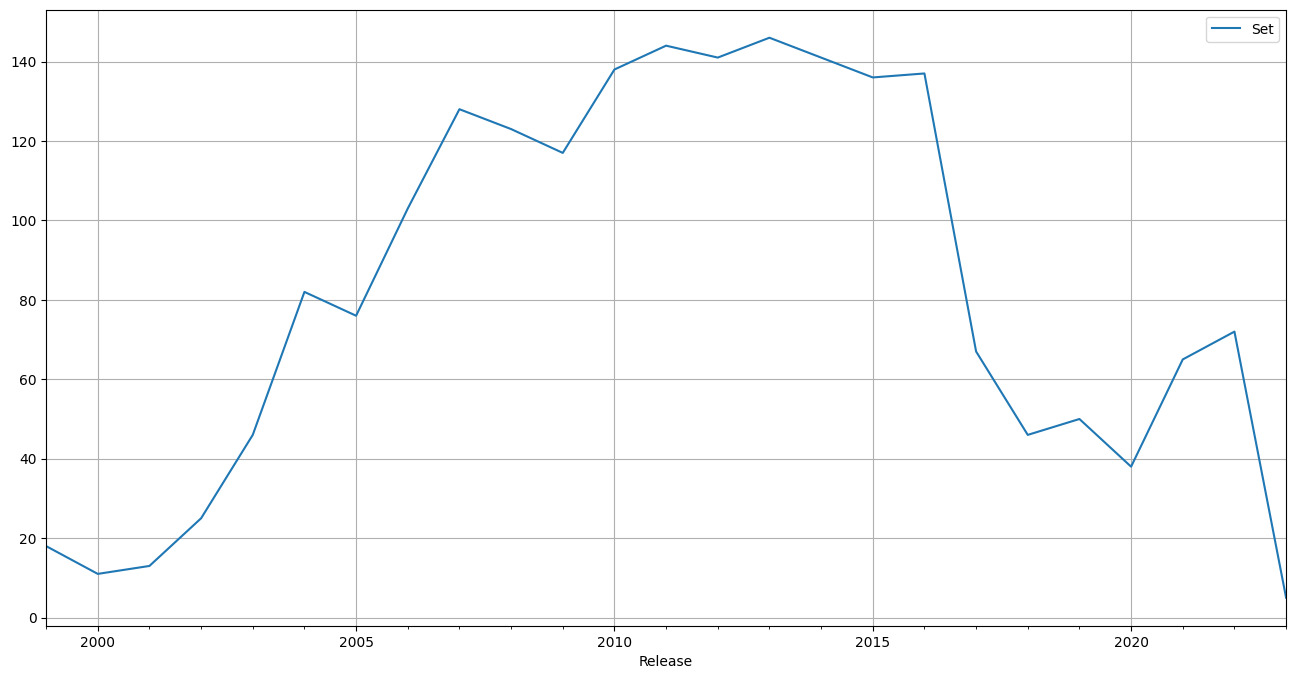

In [30]:
set_by_date.resample('Y').sum().plot(figsize= (16,8), grid = True, x_compat=False)
plt.show()

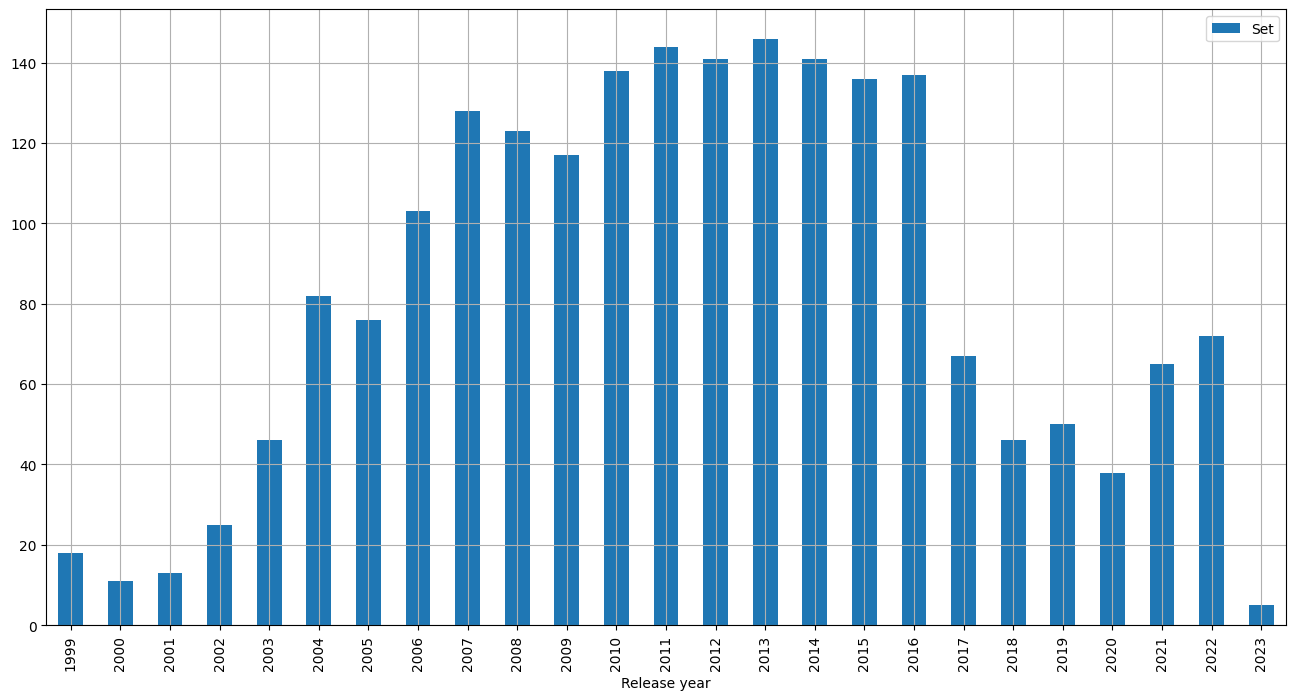

In [31]:
set_by_date.groupby(set_by_date.index.strftime('%Y')).sum().plot.bar(figsize= (16,8), grid=True, xlabel = 'Release year')
plt.show()

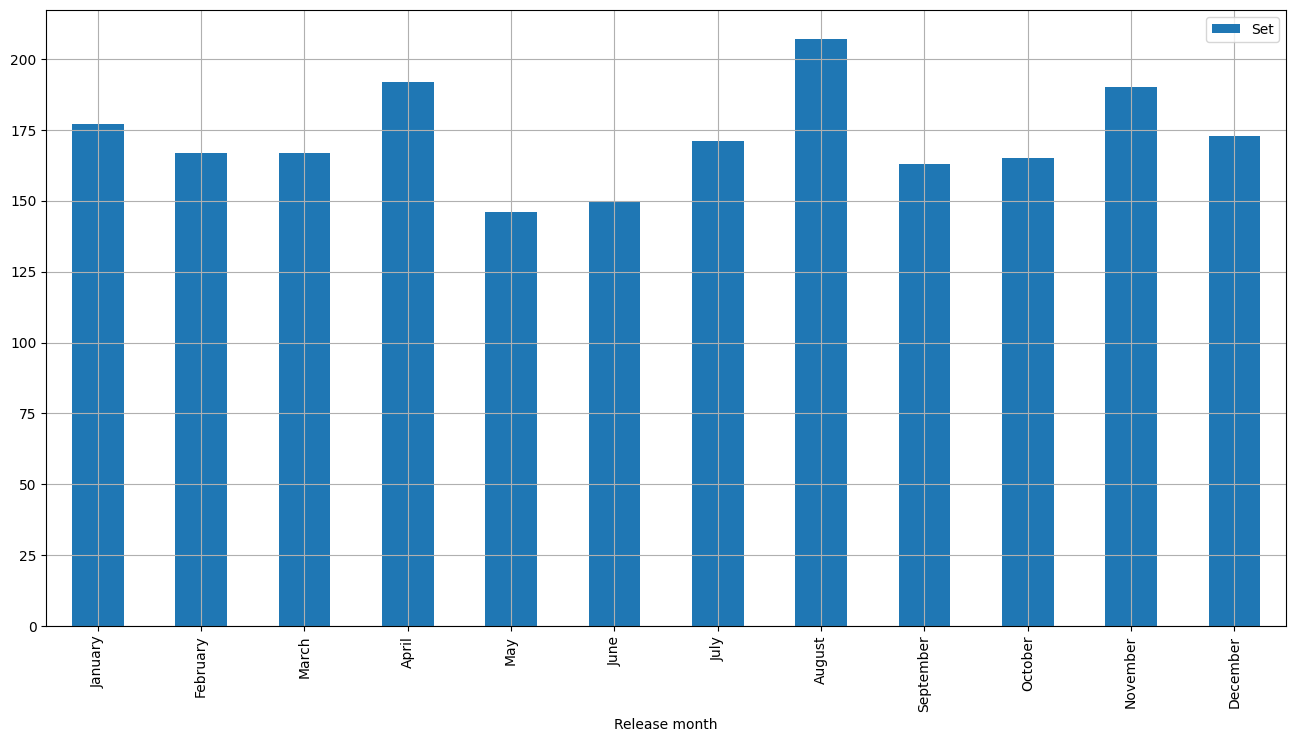

In [32]:
set_by_date.groupby(set_by_date.index.strftime('%B')).sum().sort_index(key=lambda x: pd.to_datetime(x, format='%B').month).plot.bar(figsize= (16,8), grid=True, xlabel = 'Release month')
plt.show()

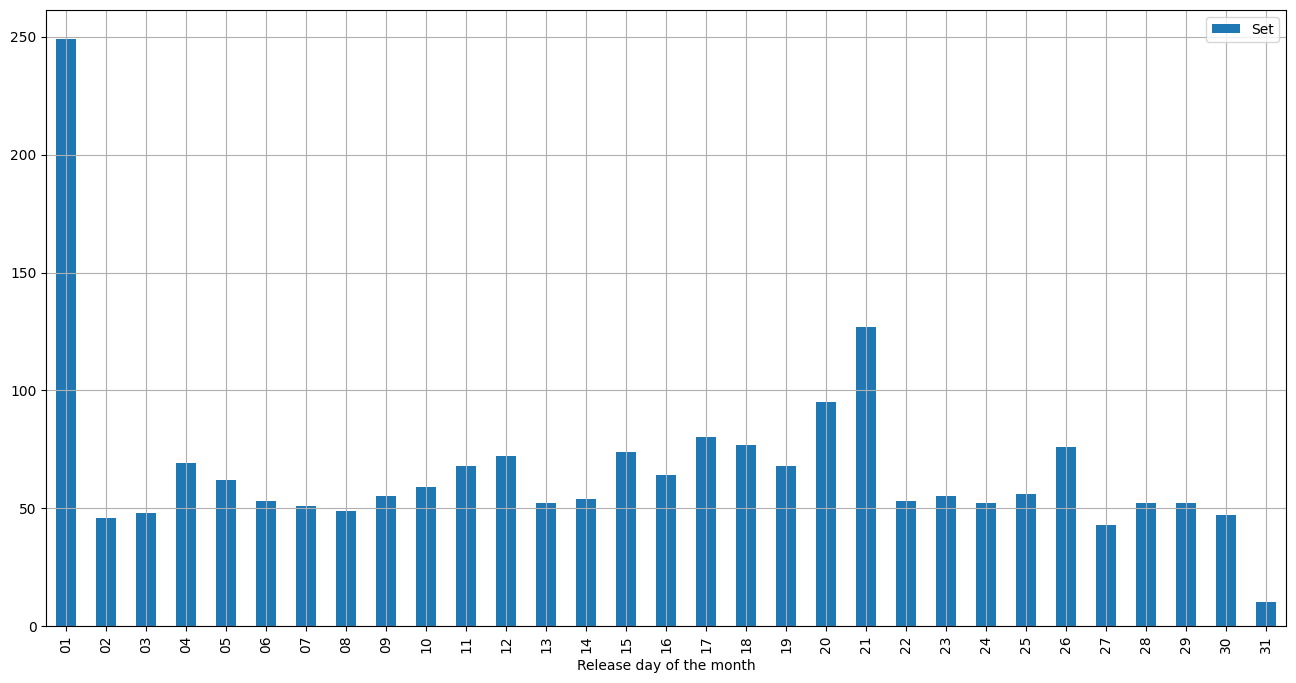

In [33]:
set_by_date.groupby(set_by_date.index.strftime('%d')).sum().plot.bar(figsize= (16,8), grid=True, xlabel = 'Release day of the month')
plt.show()

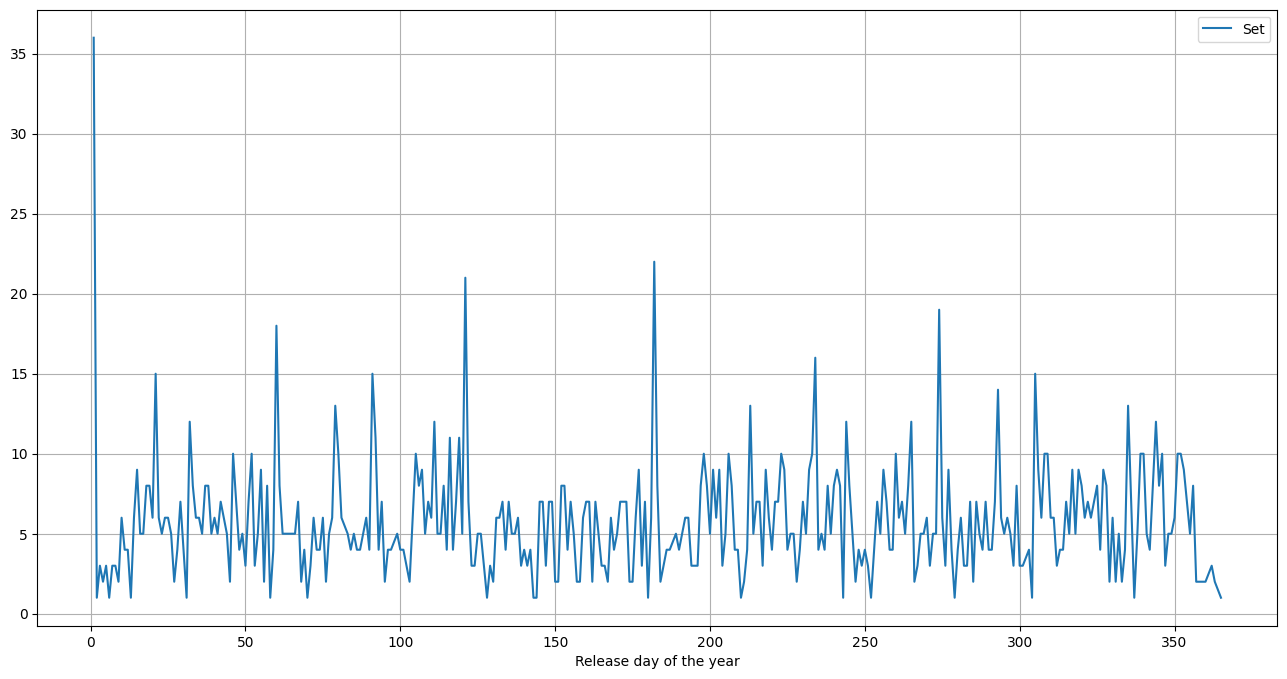

In [34]:
set_by_date.groupby(set_by_date.index.dayofyear).sum().plot(figsize= (16,8), grid=True, xlabel = 'Release day of the year')
plt.show()

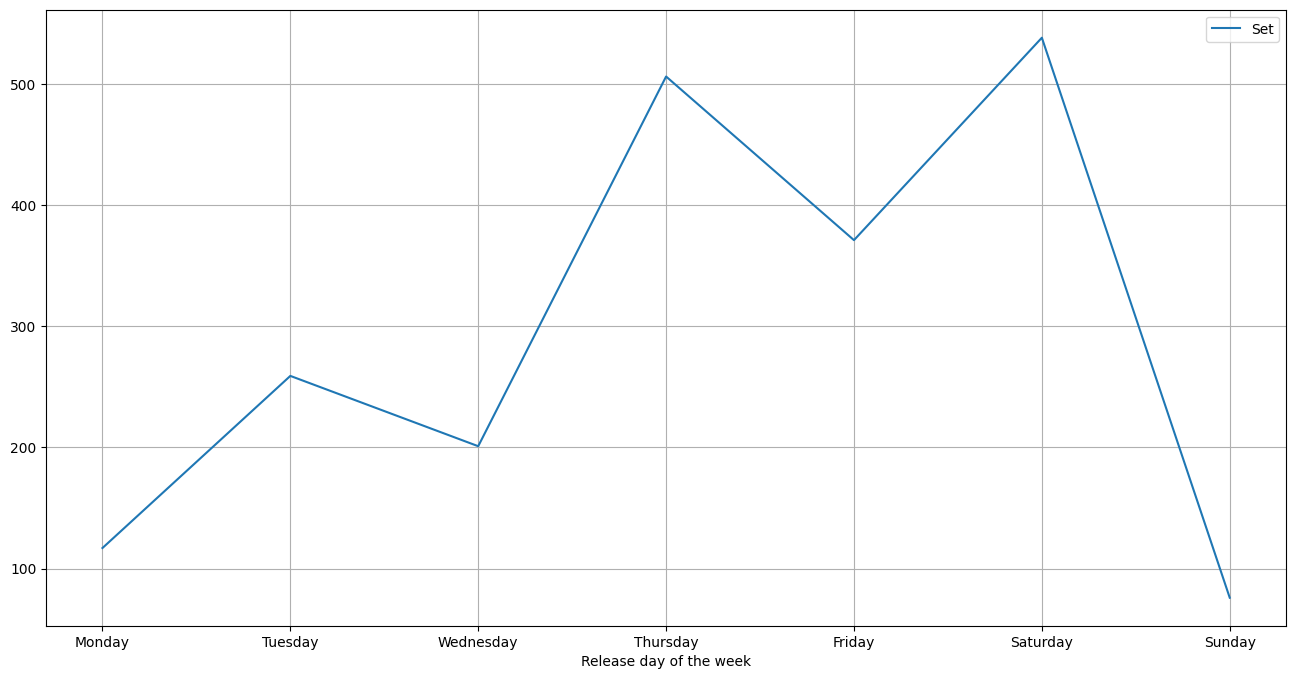

In [35]:
test = set_by_date.groupby(set_by_date.index.weekday).sum()
test.index = [calendar.day_name[i] for i in test.index.astype(int)]
# test.index
test.plot(figsize= (16,8), grid=True, xlabel = 'Release day of the week')

plt.show()

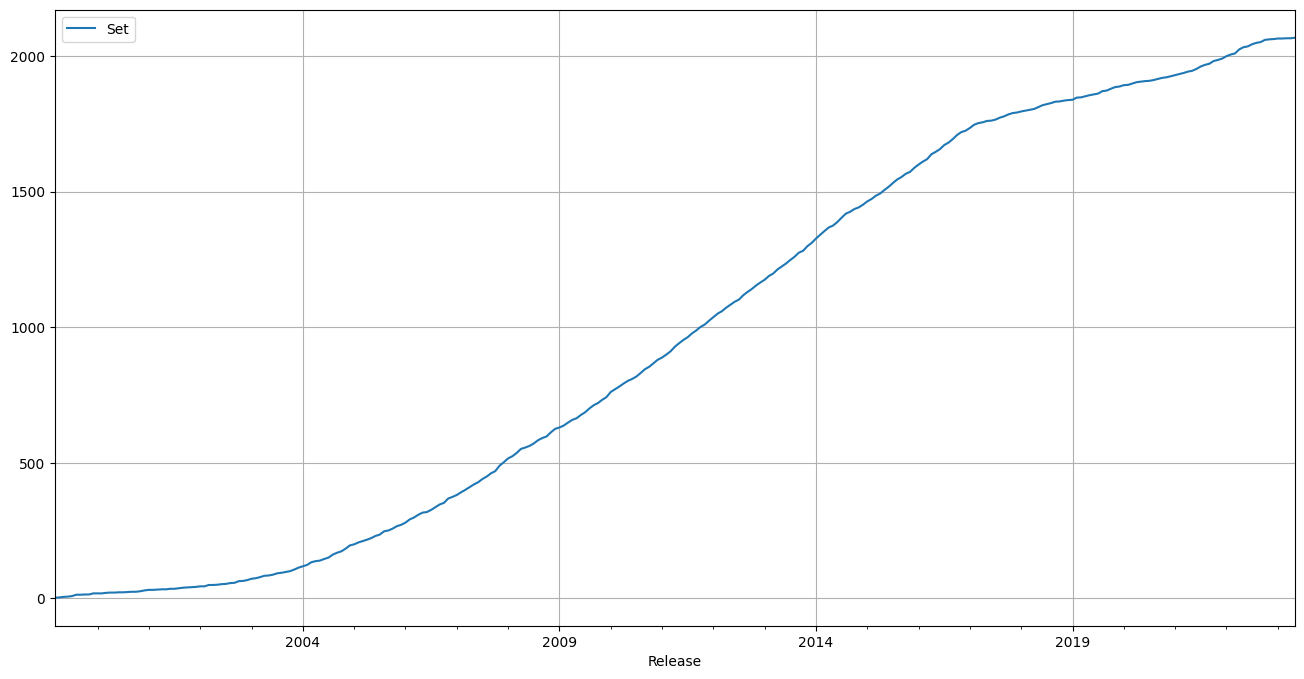

In [36]:
set_by_date.resample('M').sum().cumsum().plot(figsize= (16,8), grid = True, x_compat=False)
plt.show()

In [37]:
# set_by_date.groupby([set_by_date.index.year, set_by_date.index.year, set_by_date.index.month]).sum())
set_by_date.groupby([set_by_date.index.year, set_by_date.index.year, set_by_date.index.month]).sum().unstack()

Set                                                        \
Release          1.0   2.0   3.0   4.0   5.0   6.0   7.0   8.0   9.0   10.0   
Release Release                                                               
1999.0  1999.0    NaN   NaN   2.0   1.0   2.0   1.0   2.0   5.0   NaN   1.0   
2000.0  2000.0    NaN   NaN   2.0   1.0   NaN   1.0   NaN   1.0   1.0   NaN   
2001.0  2001.0    2.0   NaN   1.0   1.0   NaN   2.0   NaN   2.0   2.0   1.0   
2002.0  2002.0    2.0   NaN   5.0   NaN   1.0   2.0   1.0   3.0   1.0   6.0   
2003.0  2003.0    5.0   2.0   4.0   5.0   1.0   3.0   5.0   2.0   3.0   3.0   
2004.0  2004.0    5.0   5.0  10.0   4.0   2.0   6.0   5.0  11.0   7.0   5.0   
2005.0  2005.0    4.0   7.0   5.0   5.0   6.0   8.0   5.0  12.0   3.0   7.0   
2006.0  2006.0    8.0  12.0   7.0  10.0   8.0   2.0   8.0  10.0  10.0   6.0   
2007.0  2007.0    7.0  10.0   9.0  10.0  10.0   8.0  12.0   9.0  12.0   8.0   
2008.0  2008.0   14.0   8.0  12.0  15.0   5.0   6.0   9.0  12.0   8.0   6.0   
2009.0  2009.0    5.0   7.0  11.0  10.0   6.0  12.0  10.0  14.0  12.0   8.0   
2010.0  2010.0   19.0  10.0  10.0  11.0  10.0   7.0   9.0  13.0  14.0   9.0   
2011.0  2011.0    8.0  11.0  12.0  17.0  13.0  12.0  10.0  14.0  11.0  13.0   
2012.0  2012.0   13.0  13.0   9.0  13.0  11.0  11.0   8.0  16.0  12.0  11.0   
2013.0  2013.0   10.0  14.0   9.0  15.0  11.0  11.0  13.0  12.0  15.0   7.0   
2014.0  2014.0   16.0  14.0  14.0  13.0   7.0  13.0  16.0  15.0   7.0  10.0   
2015.0  2015.0   12.0   9.0  12.0   8.0  13.0  12.0  14.0  13.0   9.0  12.0   
2016.0  2016.0   12.0  11.0   9.0  18.0   9.0  10.0  15.0   9.0  13.0  15.0   
2017.0  2017.0   10.0  12.0   6.0   3.0   5.0   1.0   4.0   7.0   5.0   7.0   
2018.0  2018.0    4.0   3.0   3.0   3.0   7.0   7.0   4.0   4.0   5.0   1.0   
2019.0  2019.0    1.0   8.0   1.0   4.0   4.0   3.0   3.0   9.0   2.0   7.0   
2020.0  2020.0    5.0   1.0   5.0   5.0   2.0   2.0   1.0   3.0   4.0   4.0   
2021.0  2021.0    4.0   4.0   4.0   5.0   3.0   7.0   9.0   6.0   4.0  10.0   
2022.0  2022.0    9.0   6.0   4.0  15.0   8.0   3.0   8.0   5.0   3.0   8.0   
2023.0  2023.0    2.0   NaN   1.0   NaN   2.0   NaN   NaN   NaN   NaN   NaN   

                             
Release          11.0  12.0  
Release Release              
1999.0  1999.0    NaN   4.0  
2000.0  2000.0    2.0   3.0  
2001.0  2001.0    1.0   1.0  
2002.0  2002.0    1.0   3.0  
2003.0  2003.0    6.0   7.0  
2004.0  2004.0   10.0  12.0  
2005.0  2005.0    9.0   5.0  
2006.0  2006.0   16.0   6.0  
2007.0  2007.0   20.0  13.0  
2008.0  2008.0   15.0  13.0  
2009.0  2009.0   12.0  10.0  
2010.0  2010.0   13.0  13.0  
2011.0  2011.0    9.0  14.0  
2012.0  2012.0   13.0  11.0  
2013.0  2013.0   17.0  12.0  
2014.0  2014.0    6.0  10.0  
2015.0  2015.0    7.0  15.0  
2016.0  2016.0   11.0   5.0  
2017.0  2017.0    5.0   2.0  
2018.0  2018.0    3.0   2.0  
2019.0  2019.0    6.0   2.0  
2020.0  2020.0    2.0   4.0  
2021.0  2021.0    4.0   5.0  
2022.0  2022.0    2.0   1.0  
2023.0  2023.0    NaN   NaN

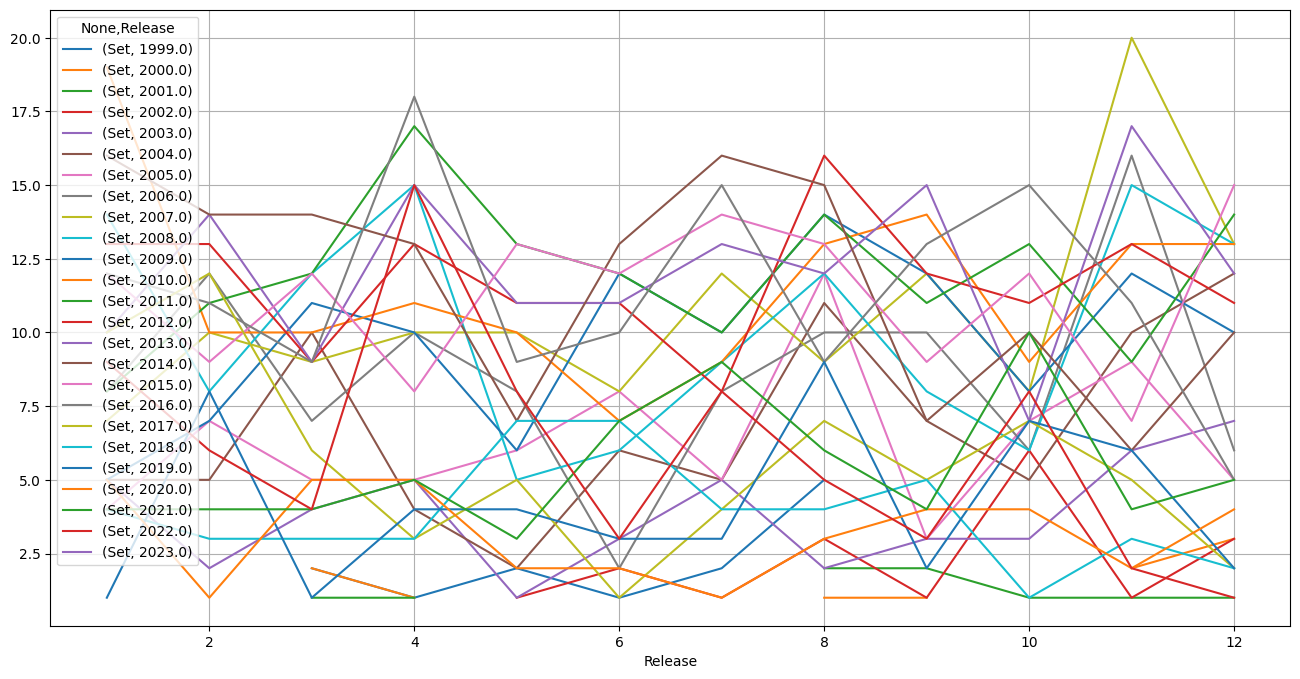

In [51]:
set_by_date.groupby([set_by_date.index.year, set_by_date.index.month]).sum().unstack(level=0).plot(figsize = (16,8), grid = True)
plt.show()

## By Cover card

In [39]:
print('Total number of cover cards:', info_df['Cover card'].explode('Cover card').nunique())

Total number of cover cards: 669


In [40]:
info_df.reset_index(names=['Set']).explode('Cover card').groupby('Cover card').nunique()

Set  Series  Set type  Modification date  \
Cover card                                                                   
A-to-Z-Dragon Buster Cannon         1       0         1                  1   
Accel Synchro Stardust Dragon       1       0         1                  1   
Accesscode Talker                   1       1         1                  1   
Adamancipator Risen - Dragite       1       0         1                  1   
Adreus, Keeper of Armageddon        1       0         1                  1   
...                               ...     ...       ...                ...   
Yamiterasu the Divine Delayer       1       1         1                  1   
Yoko, the Graceful Mayakashi        2       0         1                  2   
Yubel - The Ultimate Nightmare      2       1         2                  2   
Z-Metal Tank                        1       1         1                  1   
Zerrziel, Ruler of the Evil Eyed    1       0         1                  1   

                                  Asian-English release date  \
Cover card                                                     
A-to-Z-Dragon Buster Cannon                                0   
Accel Synchro Stardust Dragon                              0   
Accesscode Talker                                          0   
Adamancipator Risen - Dragite                              0   
Adreus, Keeper of Armageddon                               0   
...                                                      ...   
Yamiterasu the Divine Delayer                              0   
Yoko, the Graceful Mayakashi                               0   
Yubel - The Ultimate Nightmare                             0   
Z-Metal Tank                                               0   
Zerrziel, Ruler of the Evil Eyed                           0   

                                  Japanese release date  \
Cover card                                                
A-to-Z-Dragon Buster Cannon                           1   
Accel Synchro Stardust Dragon                         1   
Accesscode Talker                                     1   
Adamancipator Risen - Dragite                         1   
Adreus, Keeper of Armageddon                          1   
...                                                 ...   
Yamiterasu the Divine Delayer                         1   
Yoko, the Graceful Mayakashi                          1   
Yubel - The Ultimate Nightmare                        2   
Z-Metal Tank                                          1   
Zerrziel, Ruler of the Evil Eyed                      1   

                                  North American English release date  \
Cover card                                                              
A-to-Z-Dragon Buster Cannon                                         1   
Accel Synchro Stardust Dragon                                       0   
Accesscode Talker                                                   1   
Adamancipator Risen - Dragite                                       0   
Adreus, Keeper of Armageddon                                        0   
...                                                               ...   
Yamiterasu the Divine Delayer                                       0   
Yoko, the Graceful Mayakashi                                        1   
Yubel - The Ultimate Nightmare                                      1   
Z-Metal Tank                                                        0   
Zerrziel, Ruler of the Evil Eyed                                    0   

                                  Italian release date  \
Cover card                                               
A-to-Z-Dragon Buster Cannon                          1   
Accel Synchro Stardust Dragon                        0   
Accesscode Talker                                    1   
Adamancipator Risen - Dragite                        0   
Adreus, Keeper of Armageddon                         0   
...                                                ...   
Yami

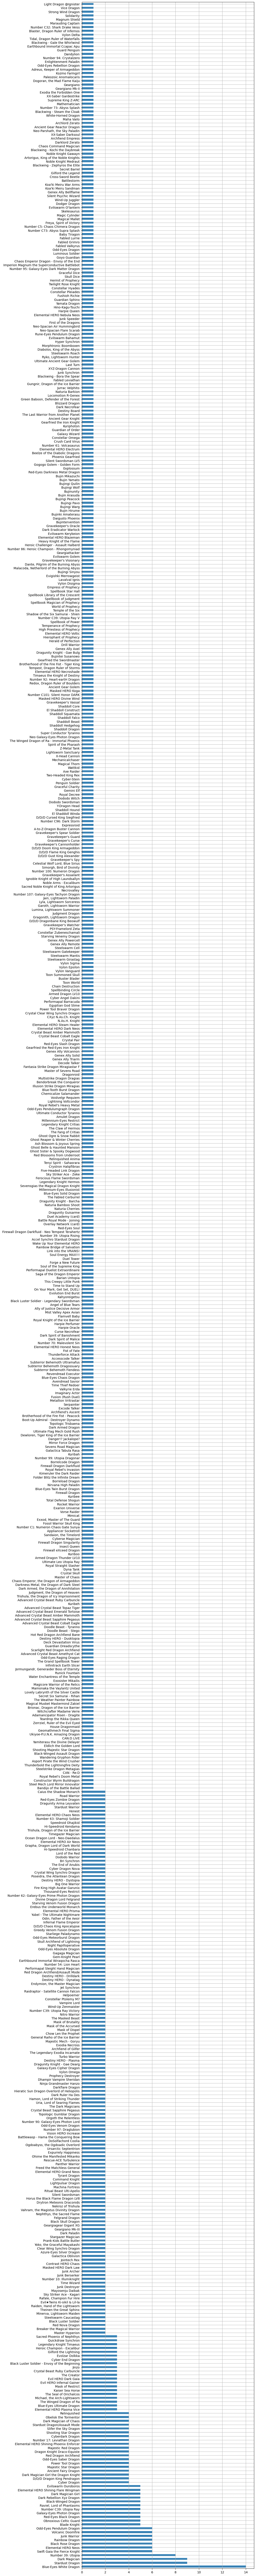

In [41]:
info_df['Cover card'].explode('Cover card').value_counts().plot.barh(figsize = (10,150), grid=True)
plt.show()

## By Set type

In [42]:
print('Total number of set types:', info_df['Set type'].explode().nunique())

Total number of set types: 37


In [43]:
info_df.reset_index(names=['Set']).explode('Set type').groupby('Set type').nunique()

Set  Cover card  Series  \
Set type                                                      
Beta set                              1           0       0   
Binder                                2           0       0   
Book promotional card                 4           0       1   
Book promotional cards               26           0       2   
Booster pack                        463         223      23   
Boss Duel Deck                        1           0       0   
Bundle                                9           0       1   
Collectible tin                      53          35       0   
Collector's Set                      11           6       0   
Core Booster                          1           1       0   
Deluxe Edition                        4           4       0   
Demo Deck                             4           1       0   
Duel Disk                             2           0       0   
Duel Disk promotional cards           5           0       0   
Duel Terminal                        34          10       0   
Duelist League participation cards   10           0       0   
Duelist Set                           5           5       0   
Enhancement Pack                      2           0       0   
Hobby League participation cards     40           0       0   
Magazine promotional card           167           7       3   
Magazine promotional cards            4           0       0   
Main Deck                             2           1       0   
Manga promotional card               33           0       4   
Participation card                   60           0       2   
Preconstructed Deck                   6           4       0   
Prize card                           16           0       1   
Prize cards                           1           0       0   
Promotional card                    136          21       6   
Promotional cards                    26           1       1   
Special Edition                      90           1       0   
Starter Deck                         38          26       0   
Structure Deck                       64          45       1   
Tournament prize card                 1           0       0   
Tournament promotional card           2           0       0   
Vendor Edition                        6           0       0   
Video game promotional card           9           0       0   
Video games promotional card         23           0       0   

                                    Modification date  \
Set type                                                
Beta set                                            1   
Binder                                              2   
Book promotional card                               4   
Book promotional cards                             26   
Booster pack                                      463   
Boss Duel Deck                                      1   
Bundle                                              9   
Collectible tin                                    53   
Collector's Set                                    11   
Core Booster                                        1   
Deluxe Edition                                      4   
Demo Deck                                           4   
Duel Disk                                           2   
Duel Disk promotional cards                         5   
Duel Terminal                                      34   
Duelist League participation cards                 10   
Duelist Set                                         5   
Enhancement Pack                                    2   
Hobby League participation cards                   40   
Magazine promotional card                         167   
Magazine promotional cards                          4   
Main Deck                                           2   
Manga promotional card                             33   
Participation card                                 60   
Preconstructed Deck                                 6   
Prize card                             

# Debug

## Has nan name/number

In [44]:
all_set_lists[all_set_lists['Name'].isna() | all_set_lists['Card number'].isna()]

Set Card number               Name  \
792     Master of Pendulum Structure Deck        <NA>               <NA>   
4454                            Booster 7        <NA>       Mushroom Man   
4455                            Booster 7        <NA>     Koumori Dragon   
4456                            Booster 7        <NA>          Jellyfish   
4457                            Booster 7        <NA>           Grappler   
...                                   ...         ...                ...   
142320                     EX Starter Box        <NA>       Reverse Trap   
142321                     EX Starter Box        <NA>        Remove Trap   
142322                     EX Starter Box        <NA>           De-Spell   
142323                     EX Starter Box        <NA>       Castle Walls   
142324                     EX Starter Box        <NA>  Ultimate Offering   

            Rarity    Print  Quantity Region    Release  
792      (Common,)     <NA>      <NA>     IT 2015-12-03  
4454     (Common,)     <NA>      <NA>     JP 2000-03-01  
4455    (Reprint,)     <NA>      <NA>     JP 2000-03-01  
4456     (Common,)     <NA>      <NA>     JP 2000-03-01  
4457     (Common,)     <NA>      <NA>     JP 2000-03-01  
...            ...      ...       ...    ...        ...  
142320        None  Reprint      <NA>     JP 1999-12-16  
142321        None  Reprint      <NA>     JP 1999-12-16  
142322        None        2      <NA>     JP 1999-12-16  
142323        None  Reprint      <NA>     JP 1999-12-16  
142324        None  Reprint      <NA>     JP 1999-12-16  

[725 rows x 8 columns]

## Has nan rarity

In [45]:
print(all_set_lists.explode('Rarity')[all_set_lists.explode('Rarity')['Rarity'].isna()]['Set'].unique())

<StringArray>
[                                                                'Advanced Event Pack 2014 Vol.1',
                                                                       'Dark Revelation Volume 2',
                                                                       'Dark Revelation Volume 1',
                                'Duel Monsters II tournament meeting experience promotional card',
 'Yu-Gi-Oh! Duel Monsters II: Dark duel Stories Duelist Legend in Tokyo Dome participation cards',
                                                                               'Dark Beginning 1',
                                                            'Advanced Tournament Pack 2013 Vol.4',
                                                   'Official Guide Starter Book promotional card',
                                                         'Starter Box pre-order promotional card',
                                                            'Advanced Tournament Pack 2016 Vol.

## Has quantity as print

In [46]:
all_set_lists[all_set_lists['Print']=='2']

Set Card number      Name Rarity Print  Quantity Region  \
142273  EX Starter Box        <NA>  De-Spell   None     2      <NA>     JP   
142322  EX Starter Box        <NA>  De-Spell   None     2      <NA>     JP   

          Release  
142273 1999-12-16  
142322 1999-12-16

In [47]:
all_set_lists[all_set_lists['Set']=='EX Starter Box']

Set Card number                           Name  Rarity  \
142225  EX Starter Box        <NA>                     Lord of D.  (New,)   
142226  EX Starter Box        <NA>  The Flute of Summoning Dragon  (New,)   
142227  EX Starter Box        <NA>                  Dark Magician    None   
142228  EX Starter Box        <NA>                   Mystical Elf    None   
142229  EX Starter Box        <NA>                      Feral Imp    None   
...                ...         ...                            ...     ...   
142320  EX Starter Box        <NA>                   Reverse Trap    None   
142321  EX Starter Box        <NA>                    Remove Trap    None   
142322  EX Starter Box        <NA>                       De-Spell    None   
142323  EX Starter Box        <NA>                   Castle Walls    None   
142324  EX Starter Box        <NA>              Ultimate Offering    None   

          Print  Quantity Region    Release  
142225     <NA>      <NA>     JP 1999-12-16  
142226     <NA>      <NA>     JP 1999-12-16  
142227     <NA>      <NA>     JP 1999-12-16  
142228     <NA>      <NA>     JP 1999-12-16  
142229     <NA>      <NA>     JP 1999-12-16  
...         ...       ...    ...        ...  
142320  Reprint      <NA>     JP 1999-12-16  
142321  Reprint      <NA>     JP 1999-12-16  
142322        2      <NA>     JP 1999-12-16  
142323  Reprint      <NA>     JP 1999-12-16  
142324  Reprint      <NA>     JP 1999-12-16  

[100 rows x 8 columns]

## Has nan release

In [48]:
print(all_set_lists[all_set_lists['Release'].isna()]['Set'].unique())

<StringArray>
[                                'Premium Pack',
 'Shonen Jump Vol. 6, Issue 9 promotional card',
               'Sneak Peek Participation Cards',
                                  'Spell Ruler',
  'Crossed Souls Sneak Peek Participation Card',
                     'The Sanctuary in the Sky',
                          'Invader of Darkness',
                               'Premium Pack 2',
                        'Structure Deck: Marik',
                   'National Championship 2011',
 ...
          'Hobby League 6 participation card B',
          'Hobby League 6 participation card C',
          'Hobby League 6 participation card D',
          'Hobby League 6 participation card E',
          'Hobby League 6 participation card F',
          'Hobby League 7 participation card A',
          'Hobby League 7 participation card B',
          'Hobby League 7 participation card C',
          'Hobby League 7 participation card D',
                      'Judge promotional cards']
L